In [2]:
import math
import os.path

from src.tf_models import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform, metrics
from umap import UMAP
import datetime
from scipy.signal import argrelextrema
import os
import glob
import pandas as pd
import scipy
from skimage import io
import csv
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity as ssim
import math
import plotly.express as px

from src.tf_utils import SaveImageCallback

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
all_images = np.load('data/saved np/images_no_filters.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
        #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [3]:

image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
# net.built=True
# net.load_weights('data/saved_models/u2net_loss=0.0089.h5')

model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [ ]:
model.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_images_rgb[:100], all_images_rgb[:100], test_size=0.2)
name = f'u2net_{datetime.datetime.now().date()}'
log_dir = f'data/logs/{name}_tensorboard/'
checkpoint_filepath = f'data/logs/{name}_checkpoint/checkpoints/'
csv_log_path = f'data/logs/train_csv/'
csv_log_filepath = csv_log_path + f'{name}.csv'
images_save_dir = f'data/logs/{name}_val_images/'

if not os.path.exists(csv_log_filepath):
    os.makedirs(csv_log_filepath)

if not os.path.exists(csv_log_filepath):
    with open(csv_log_filepath, 'wb') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='#', quoting=csv.QUOTE_MINIMAL)


In [ ]:
optim = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

csv_logger = tf.keras.callbacks.CSVLogger(csv_log_filepath)

n_samples = 3

save_callback = SaveImageCallback(x_test, images_save_dir, n_samples, net)

model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=2,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[tensorboard_callback,
                               model_checkpoint_callback,
                               early_stop_callback,
                               csv_logger,
                               save_callback])

In [ ]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
n = 1

predict = net(tf.expand_dims(x_test[n], axis=0))[0][0]

original = x_test[n]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(predict, cmap='gray')
ax1.set_title('Autoencoder', fontsize=15)

ax2.imshow(original, cmap='gray')
ax2.set_title('Original', fontsize=15)
#plt.savefig(f'autoencoder{name}.png')
plt.show()

In [ ]:
net(tf.expand_dims(images[0,0], axis=0))[1][0].numpy().shape

(32, 32, 512)

## Evaluation

In [4]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)

model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')
model.built = True
model.load_weights('data/logs/u2net_2021-11-19_checkpoint/checkpoints/')
images = np.load('data/saved np/images_no_filters.npy', allow_pickle=True)
name = f'u2net_{datetime.datetime.now().date()}'

In [ ]:
mse_losses = []
ssim_losses = []

for i, images_list in enumerate(images):
    for image in images_list:
        original_image = transform.resize(image, image_shape)
        predicted_image = model.predict(tf.expand_dims(original_image, axis=0))[0]
        mse_losses.append(metrics.mean_squared_error(original_image, predicted_image))
        ssim_losses.append(metrics.structural_similarity(original_image, predicted_image, multichannel=True))
        mse_losses = np.array(mse_losses)

ssim_losses = np.array(ssim_losses)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

for i, images_list in enumerate(images):
    start = 0
    for j in range(i):
        start += len(images[j])
    end = start + len(images_list)

    x = np.arange(mse_losses.shape[0])[start:end]
    mse_y = mse_losses[start:end]
    ssim_y = ssim_losses[start:end]

    ax1.plot(x, mse_y)
    ax1.scatter(x, mse_y)

    ax2.plot(x, ssim_y)
    ax2.scatter(x, ssim_y)

plt.rcParams['font.size'] = '20'

ax1.legend(names, fontsize=15)
ax1.set_title('MSE image losses', fontsize=20)
ax1.set_xlabel('image number', fontsize=20)
ax1.set_ylabel('MSE loss', fontsize=20)

ax2.legend(names, fontsize=15)
ax2.set_title('Structural image similarity', fontsize=20)
ax2.set_xlabel('image number', fontsize=20)
ax2.set_ylabel('SSIM similarity', fontsize=20)

plt.savefig(f'mse_ssim_losses_{name}.png')

plt.show()

## Visualization

In [5]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)

model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')
model.built = True
model.load_weights('data/logs/u2net_2021-11-19_checkpoint/checkpoints/')
images = np.load('data/saved np/images_no_filters.npy')


In [6]:

images_embs = []
for i, images_list in enumerate(images):

    images_embs.append([])
    for image_gray in images_list:
        emb = net(tf.expand_dims(image_gray / 255, axis=0))[1][0].numpy()
        images_embs[i].append(emb)


images_embs=np.array(images_embs)

In [7]:
images_embs.shape

(5, 90, 32, 32, 512)

In [ ]:
np.save('data/saved np/images_embs.npy', images_embs)

In [ ]:
# вывод фильтров свертки

image = images[0][0]
img = net(tf.expand_dims(image / 255, axis=0))

for level in range(1, 7):
    filters = img[level][0].numpy()

    filters_num = filters.shape[-1]
    n_rows = int(math.sqrt(filters_num))

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_rows, figsize=(20, 20))
    step = 0
    for i in range(n_rows):
        for j in range(n_rows):
            ax[i][j].imshow(filters[:, :, step], cmap='gray')
            step += 1
    # plt.savefig(f'cnn_filters_level_{6 - level}.png')
plt.show()


In [6]:
images_embs = np.load('data/saved np/images_embs.npy')

In [7]:
seed = 51
umap_2d = UMAP(random_state=seed)
old_shape=images_embs.shape
umaped_vct_2d = umap_2d.fit_transform(images_embs.reshape(-1,images_embs.shape[-1]))
legend = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
          'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

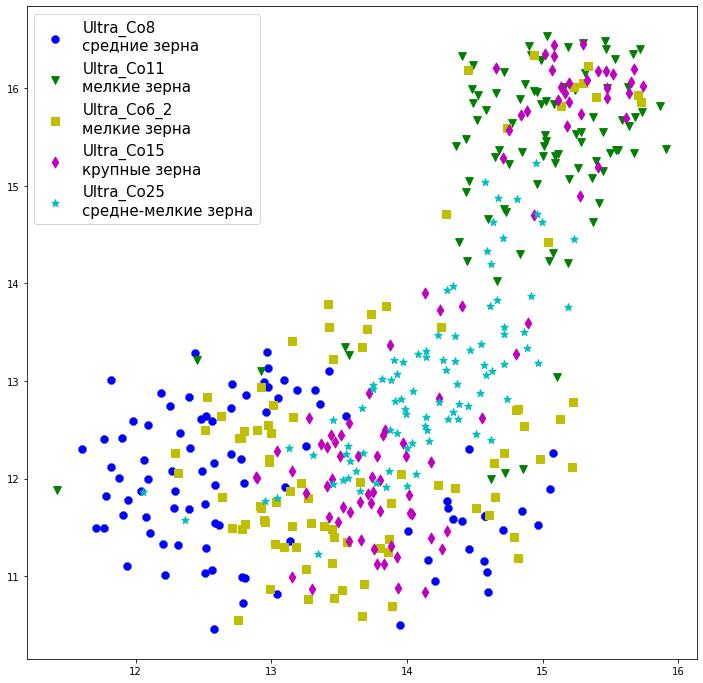

In [10]:

N = 12
M = 12
fontsize = 15
dot_size = 60

embs_scatter=umaped_vct_2d.reshape((5,90,-1))

fig, ax = plt.subplots(figsize=(N, M))

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f_vects = []

for i,emb_vects  in enumerate(embs_scatter):
    ax.scatter(emb_vects[:,0],emb_vects[:,1], color=colors[i], s=dot_size,marker=markers[i])

ax.legend(legend, fontsize=fontsize)
plt.savefig(f'embs_space_u2net_seed={seed}.png')
plt.show()

In [2]:
def get_emb_distr(step, projection_axis, eps):
    axis_start = f_vects[0][projection_axis].min()
    axis_end = f_vects[0][projection_axis].max()

    for vects in f_vects:
        min_val = vects[projection_axis].min()
        max_val = vects[projection_axis].max()

        if min_val < axis_start:
            axis_start = min_val

        if max_val > axis_end:
            axis_end = max_val

    axis_step = step * (axis_end - axis_start)
    axis_eps = eps * (axis_end - axis_start)
    axis_vals = np.arange(axis_start, axis_end, axis_step)

    points_distr = []

    for i, vects in enumerate(f_vects):
        points_distr.append([])
        for axis_val in axis_vals:
            counter = 0
            for point in vects[projection_axis]:
                if abs(point - axis_val) <= axis_eps:
                    counter += 1
            points_distr[i].append(counter)

    for i, distr in enumerate(points_distr):
        points_distr[i] = np.array(points_distr[i]) / sum(distr)

    return axis_vals, np.array(points_distr), axis_step, axis_eps

In [ ]:
names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

step = 0.05
size=4
# eps=step/2
eps = 0.25
projection_axis = 1

x_axis_vals, x_points_distr, x_step, x_eps = get_emb_distr(step, projection_axis=0, eps=eps)
y_axis_vals, y_points_distr, y_step, y_eps = get_emb_distr(step, projection_axis=1, eps=eps)

for i in range(len(x_points_distr)):
    # y projection
    ax1.scatter(y_axis_vals, y_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])
    ax1.plot(y_axis_vals, y_points_distr[i], color=colors[i])
    ax1.legend(names + [
        f'шаг={round(y_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(y_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
               fontsize=15)
    ax1.set_xlabel('y val', fontsize=20)
    ax1.set_ylabel('norm(count)', fontsize=20)

    # x prjection
    ax2.scatter(x_axis_vals, x_points_distr[i], edgecolor=colors[i], s=size, marker=markers[i])
    ax2.plot(x_axis_vals, x_points_distr[i], color=colors[i])
    ax2.legend(names + [
        f'шаг={round(x_step, 2)}, доля от длины оси={int(step * 100)}%\neps={round(x_eps, 2)}, доля от длины оси={int(eps * 100)}%'],
               fontsize=15)
    ax2.set_xlabel('x val', fontsize=20)
    ax2.set_ylabel('norm(count)', fontsize=20)

# plt.savefig(f'embs projection step={step} eps={eps}.png')
plt.show()

In [ ]:
umap_3d = UMAP(n_components=3)
umaped_vct_3d = umap_3d.fit_transform(images_embs.reshape(-1,images_embs.shape[-1]))

In [ ]:
N = 15
size = 20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна',
         'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors = ['b', 'g', 'y', 'm', 'c']
markers = ['8', 'v', 's', 'd', '*', ]


embs_3d_scatter=umaped_vct_3d.reshape((5,90,-1))

scatters = []
for i, scatter_list in enumerate(embs_3d_scatter):

    for point in scatter_list:
        scatters.append([point[0], point[1], point[2], 0.2, names[i], i + 1])

column_values = ['x', 'y', 'z', 'width', 'name', 'class']

# creating the dataframe
df = pd.DataFrame(data=scatters,
                  columns=column_values)

fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='name')
fig.show()